In [1]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta

In [2]:
import numpy as np
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [3]:
# Set timeframe to pull data (365 * years)
lookback = 365 * 2
end_date = datetime.now()
start_date = datetime.now() - timedelta(days=lookback)
print(end_date)
print(start_date)

2020-09-28 17:45:50.378693
2018-09-29 17:45:50.378693


In [4]:
# Construct training start and end dates
training_end = '2020-04-01'

# Construct testing start and end dates
testing_start =  '2020-04-02'

In [5]:
ticker = ['AMZN']

In [6]:
# Pull daily close information for symbols
df=yf.download(ticker,start_date,end_date)
df.head(-1)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-10-01,2021.989990,2033.189941,2003.599976,2004.359985,2004.359985,3460500
2018-10-02,1999.989990,2013.390015,1965.770020,1971.310059,1971.310059,5400700
2018-10-03,1981.699951,1989.699951,1949.810059,1952.760010,1952.760010,5253100
2018-10-04,1949.000000,1956.000000,1896.569946,1909.420044,1909.420044,7257000
2018-10-05,1917.989990,1929.079956,1862.829956,1889.650024,1889.650024,6822300
...,...,...,...,...,...,...
2020-09-21,2906.500000,2962.000000,2871.000000,2960.469971,2960.469971,6117900
2020-09-22,3033.840088,3133.989990,3000.199951,3128.989990,3128.989990,6948800
2020-09-23,3120.429932,3127.000000,2992.379883,2999.860107,2999.860107,5652700


In [7]:
# Drop NAs and calculate daily percent return
df.index = pd.to_datetime(df.index)
df.index.rename('Timestamp', inplace=True)
df['daily_return'] = df['Adj Close'].pct_change()
df.dropna(inplace=True)
df.head(-1)

,Open,High,Low,Close,Adj Close,Volume,daily_return
Timestamp,,,,,,,
2018-10-02,1999.989990,2013.390015,1965.770020,1971.310059,1971.310059,5400700,-0.016489
2018-10-03,1981.699951,1989.699951,1949.810059,1952.760010,1952.760010,5253100,-0.009410
2018-10-04,1949.000000,1956.000000,1896.569946,1909.420044,1909.420044,7257000,-0.022194
2018-10-05,1917.989990,1929.079956,1862.829956,1889.650024,1889.650024,6822300,-0.010354
2018-10-08,1874.000000,1902.000000,1830.660034,1864.420044,1864.420044,7393200,-0.013352
...,...,...,...,...,...,...,...
2020-09-21,2906.500000,2962.000000,2871.000000,2960.469971,2960.469971,6117900,0.001882
2020-09-22,3033.840088,3133.989990,3000.199951,3128.989990,3128.989990,6948800,0.056923
2020-09-23,3120.429932,3127.000000,2992.379883,2999.860107,2999.860107,5652700,-0.041269


#### Construct Exponential Moving Average of Closing Prices (Trading Signal, Feature One)

In [8]:
# Set short and long windows
short_window = 1
long_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
df['fast_close'] = df['Adj Close'].ewm(halflife=short_window).mean()
df['slow_close'] = df['Adj Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
df['crossover_long'] = np.where(df['fast_close'] > df['slow_close'], 1.0, 0.0)
df['crossover_short'] = np.where(df['fast_close'] < df['slow_close'], -1.0, 0.0)
df['crossover_signal'] = df['crossover_long'] + df['crossover_short']

df.head(-1)

,Open,High,Low,Close,Adj Close,Volume,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
Timestamp,,,,,,,,,,,,
2018-10-02,1999.989990,2013.390015,1965.770020,1971.310059,1971.310059,5400700,-0.016489,1971.310059,1971.310059,0.0,0.0,0.0
2018-10-03,1981.699951,1989.699951,1949.810059,1952.760010,1952.760010,5253100,-0.009410,1958.943359,1961.713715,0.0,-1.0,-1.0
2018-10-04,1949.000000,1956.000000,1896.569946,1909.420044,1909.420044,7257000,-0.022194,1930.644322,1943.061276,0.0,-1.0,-1.0
2018-10-05,1917.989990,1929.079956,1862.829956,1889.650024,1889.650024,6822300,-0.010354,1908.780697,1928.289795,0.0,-1.0,-1.0
2018-10-08,1874.000000,1902.000000,1830.660034,1864.420044,1864.420044,7393200,-0.013352,1885.884876,1913.686636,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-21,2906.500000,2962.000000,2871.000000,2960.469971,2960.469971,6117900,0.001882,2984.040772,3171.278705,0.0,-1.0,-1.0
2020-09-22,3033.840088,3133.989990,3000.199951,3128.989990,3128.989990,6948800,0.056923,3056.515381,3168.446756,0.0,-1.0,-1.0
2020-09-23,3120.429932,3127.000000,2992.379883,2999.860107,2999.860107,5652700,-0.041269,3028.187744,3157.157013,0.0,-1.0,-1.0


#### Plot Exponential Moving Average of Closing Prices

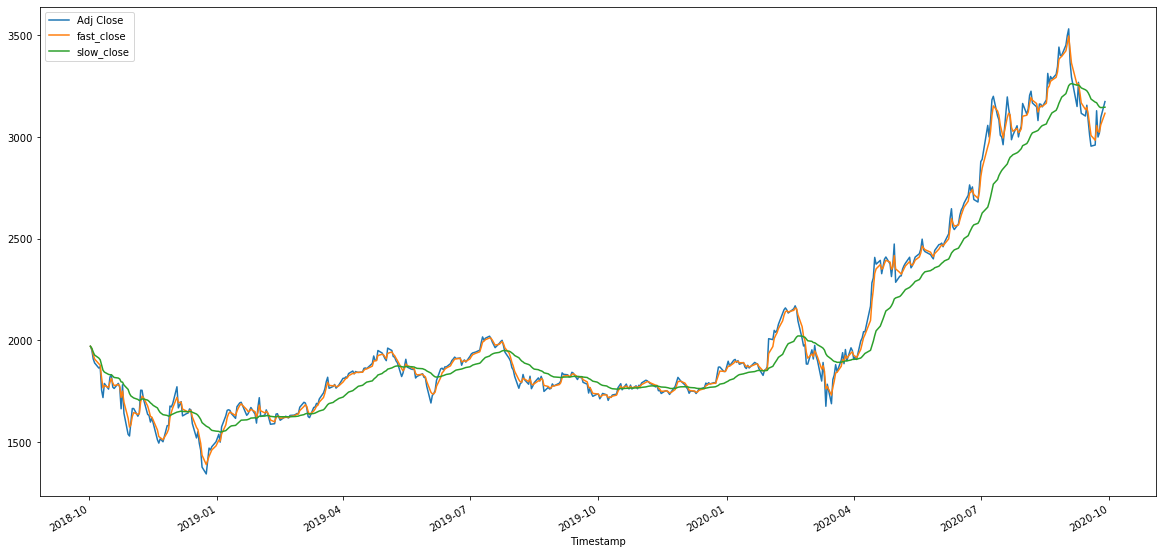

In [9]:
# Plot the EMA of closing prices
df[['Adj Close', 'fast_close', 'slow_close']].plot(figsize=(20,10));

#### Construct Exponential Moving Average of Daily Return Volatility (Trading Signal, Feature Two)

In [10]:
# Set short and long volatility windows
short_vol_window = 1
long_vol_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows
df['fast_vol'] = df['daily_return'].ewm(halflife=short_vol_window).std()
df['slow_vol'] = df['daily_return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
df['vol_trend_long'] = np.where(df['fast_vol'] < df['slow_vol'], 1.0, 0.0)
df['vol_trend_short'] = np.where(df['fast_vol'] > df['slow_vol'], -1.0, 0.0) 
df['vol_trend_signal'] = df['vol_trend_long'] + df['vol_trend_short']

df.head(-1)

,Open,High,Low,Close,Adj Close,Volume,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Timestamp,,,,,,,,,,,,,,,,,
2018-10-02,1999.989990,2013.390015,1965.770020,1971.310059,1971.310059,5400700,-0.016489,1971.310059,1971.310059,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2018-10-03,1981.699951,1989.699951,1949.810059,1952.760010,1952.760010,5253100,-0.009410,1958.943359,1961.713715,0.0,-1.0,-1.0,0.005006,0.005006,0.0,-1.0,-1.0
2018-10-04,1949.000000,1956.000000,1896.569946,1909.420044,1909.420044,7257000,-0.022194,1930.644322,1943.061276,0.0,-1.0,-1.0,0.007411,0.006507,0.0,-1.0,-1.0
2018-10-05,1917.989990,1929.079956,1862.829956,1889.650024,1889.650024,6822300,-0.010354,1908.780697,1928.289795,0.0,-1.0,-1.0,0.006729,0.006023,0.0,-1.0,-1.0
2018-10-08,1874.000000,1902.000000,1830.660034,1864.420044,1864.420044,7393200,-0.013352,1885.884876,1913.686636,0.0,-1.0,-1.0,0.004605,0.005154,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-21,2906.500000,2962.000000,2871.000000,2960.469971,2960.469971,6117900,0.001882,2984.040772,3171.278705,0.0,-1.0,-1.0,0.014769,0.022341,1.0,0.0,1.0
2020-09-22,3033.840088,3133.989990,3000.199951,3128.989990,3128.989990,6948800,0.056923,3056.515381,3168.446756,0.0,-1.0,-1.0,0.040911,0.026653,0.0,-1.0,-1.0
2020-09-23,3120.429932,3127.000000,2992.379883,2999.860107,2999.860107,5652700,-0.041269,3028.187744,3157.157013,0.0,-1.0,-1.0,0.049651,0.027761,0.0,-1.0,-1.0


#### Plot Exponential Moving Average of Daily Return Volatility

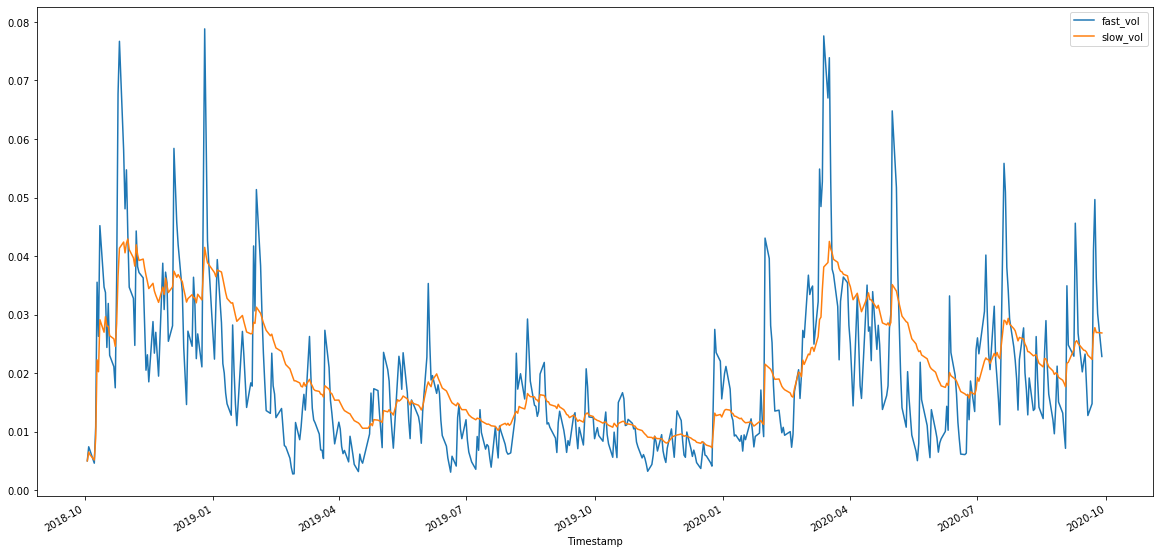

In [11]:
# Plot the EMA of daily return volatility
df[['fast_vol', 'slow_vol']].plot(figsize=(20,10));

#### Construct Bollinger Band (Trading Signal, Feature Three)

In [12]:
# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
df['bollinger_mid_band'] = df['Close'].rolling(window=bollinger_window).mean()
df['bollinger_std'] = df['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
df['bollinger_upper_band']  = df['bollinger_mid_band'] + (df['bollinger_std'] * 1)
df['bollinger_lower_band']  = df['bollinger_mid_band'] - (df['bollinger_std'] * 1)

# Calculate bollinger band trading signal
df['bollinger_long'] = np.where(df['Close'] < df['bollinger_lower_band'], 1.0, 0.0)
df['bollinger_short'] = np.where(df['Close'] > df['bollinger_upper_band'], -1.0, 0.0)
df['bollinger_signal'] = df['bollinger_long'] + df['bollinger_short']

df.head(-1)

,Open,High,Low,Close,Adj Close,Volume,daily_return,fast_close,slow_close,crossover_long,...,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-10-02,1999.989990,2013.390015,1965.770020,1971.310059,1971.310059,5400700,-0.016489,1971.310059,1971.310059,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-10-03,1981.699951,1989.699951,1949.810059,1952.760010,1952.760010,5253100,-0.009410,1958.943359,1961.713715,0.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-10-04,1949.000000,1956.000000,1896.569946,1909.420044,1909.420044,7257000,-0.022194,1930.644322,1943.061276,0.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-10-05,1917.989990,1929.079956,1862.829956,1889.650024,1889.650024,6822300,-0.010354,1908.780697,1928.289795,0.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-10-08,1874.000000,1902.000000,1830.660034,1864.420044,1864.420044,7393200,-0.013352,1885.884876,1913.686636,0.0,...,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-21,2906.500000,2962.000000,2871.000000,2960.469971,2960.469971,6117900,0.001882,2984.040772,3171.278705,0.0,...,1.0,0.0,1.0,3250.642017,179.986574,3430.628590,3070.655443,1.0,0.0,1.0
2020-09-22,3033.840088,3133.989990,3000.199951,3128.989990,3128.989990,6948800,0.056923,3056.515381,3168.446756,0.0,...,0.0,-1.0,-1.0,3241.718518,181.439641,3423.158160,3060.278877,0.0,0.0,0.0
2020-09-23,3120.429932,3127.000000,2992.379883,2999.860107,2999.860107,5652700,-0.041269,3028.187744,3157.157013,0.0,...,0.0,-1.0,-1.0,3224.387024,187.363612,3411.750636,3037.023411,1.0,0.0,1.0


#### Plot Bollinger Bands

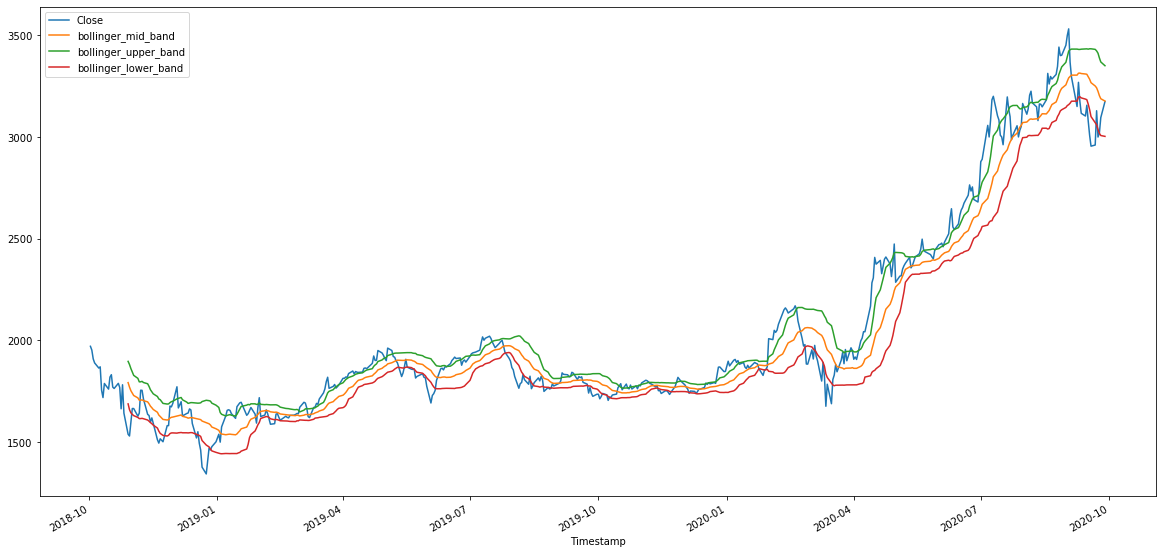

In [13]:
# Plot the Bollinger Bands for closing prices
df[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10));

In [14]:
# Set index as datetime object and drop extraneous columns
#df.set_index(pd.to_datetime(df['Timestamp'], infer_datetime_format=True), inplace=True)
#df.drop(columns=['Timestamp'], inplace=True)
#df.head(-1)

In [15]:
# Set x variable list of features
x_var_list = ['crossover_signal', 'vol_trend_signal', 'bollinger_signal']

# Filter by x-variable list
df[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Timestamp,,,
2020-09-22,-1.0,-1.0,0.0
2020-09-23,-1.0,-1.0,1.0
2020-09-24,-1.0,-1.0,0.0
2020-09-25,-1.0,-1.0,0.0
2020-09-28,-1.0,1.0,0.0


In [16]:
# Shift DataFrame values by 1
df[x_var_list] = df[x_var_list].shift(1)
df[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Timestamp,,,
2020-09-22,-1.0,1.0,1.0
2020-09-23,-1.0,-1.0,0.0
2020-09-24,-1.0,-1.0,1.0
2020-09-25,-1.0,-1.0,0.0
2020-09-28,-1.0,-1.0,0.0


In [17]:
# Drop NAs and replace positive/negative infinity values
df.dropna(subset=x_var_list, inplace=True)
df.dropna(subset=['daily_return'], inplace=True)
df = df.replace([np.inf, -np.inf], np.nan)
df.head(-1)

,Open,High,Low,Close,Adj Close,Volume,daily_return,fast_close,slow_close,crossover_long,...,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-10-03,1981.699951,1989.699951,1949.810059,1952.760010,1952.760010,5253100,-0.009410,1958.943359,1961.713715,0.0,...,0.0,-1.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-10-04,1949.000000,1956.000000,1896.569946,1909.420044,1909.420044,7257000,-0.022194,1930.644322,1943.061276,0.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-10-05,1917.989990,1929.079956,1862.829956,1889.650024,1889.650024,6822300,-0.010354,1908.780697,1928.289795,0.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-10-08,1874.000000,1902.000000,1830.660034,1864.420044,1864.420044,7393200,-0.013352,1885.884876,1913.686636,0.0,...,1.0,0.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-10-09,1859.989990,1896.680054,1852.319946,1870.319946,1870.319946,4772900,0.003164,1877.978880,1905.151232,0.0,...,0.0,-1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-21,2906.500000,2962.000000,2871.000000,2960.469971,2960.469971,6117900,0.001882,2984.040772,3171.278705,0.0,...,1.0,0.0,1.0,3250.642017,179.986574,3430.628590,3070.655443,1.0,0.0,1.0
2020-09-22,3033.840088,3133.989990,3000.199951,3128.989990,3128.989990,6948800,0.056923,3056.515381,3168.446756,0.0,...,0.0,-1.0,1.0,3241.718518,181.439641,3423.158160,3060.278877,0.0,0.0,1.0
2020-09-23,3120.429932,3127.000000,2992.379883,2999.860107,2999.860107,5652700,-0.041269,3028.187744,3157.157013,0.0,...,0.0,-1.0,-1.0,3224.387024,187.363612,3411.750636,3037.023411,1.0,0.0,0.0


In [18]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
df['Positive Return'] = np.where(df['daily_return'] > 0, 1.0, 0.0)
df.head(-1)

,Open,High,Low,Close,Adj Close,Volume,daily_return,fast_close,slow_close,crossover_long,...,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,Positive Return
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-10-03,1981.699951,1989.699951,1949.810059,1952.760010,1952.760010,5253100,-0.009410,1958.943359,1961.713715,0.0,...,-1.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2018-10-04,1949.000000,1956.000000,1896.569946,1909.420044,1909.420044,7257000,-0.022194,1930.644322,1943.061276,0.0,...,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2018-10-05,1917.989990,1929.079956,1862.829956,1889.650024,1889.650024,6822300,-0.010354,1908.780697,1928.289795,0.0,...,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2018-10-08,1874.000000,1902.000000,1830.660034,1864.420044,1864.420044,7393200,-0.013352,1885.884876,1913.686636,0.0,...,0.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2018-10-09,1859.989990,1896.680054,1852.319946,1870.319946,1870.319946,4772900,0.003164,1877.978880,1905.151232,0.0,...,-1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-21,2906.500000,2962.000000,2871.000000,2960.469971,2960.469971,6117900,0.001882,2984.040772,3171.278705,0.0,...,0.0,1.0,3250.642017,179.986574,3430.628590,3070.655443,1.0,0.0,1.0,1.0
2020-09-22,3033.840088,3133.989990,3000.199951,3128.989990,3128.989990,6948800,0.056923,3056.515381,3168.446756,0.0,...,-1.0,1.0,3241.718518,181.439641,3423.158160,3060.278877,0.0,0.0,1.0,1.0
2020-09-23,3120.429932,3127.000000,2992.379883,2999.860107,2999.860107,5652700,-0.041269,3028.187744,3157.157013,0.0,...,-1.0,-1.0,3224.387024,187.363612,3411.750636,3037.023411,1.0,0.0,0.0,0.0


In [19]:
# Format training & testing start and end dates
training_start = df.index.min().strftime(format= '%Y-%m-%d')
testing_end = df.index.max().strftime(format= '%Y-%m-%d')

In [20]:
# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2018-10-03
Training End: 2020-04-01
Testing Start: 2020-04-02
Testing End: 2020-09-28


In [21]:
# Construct the X_train dataset
X_train = df[x_var_list][training_start:training_end]


X_train.head(-1)

,crossover_signal,vol_trend_signal,bollinger_signal
Timestamp,,,
2018-10-03,0.0,0.0,0.0
2018-10-04,-1.0,-1.0,0.0
2018-10-05,-1.0,-1.0,0.0
2018-10-08,-1.0,-1.0,0.0
2018-10-09,-1.0,1.0,0.0
...,...,...,...
2020-03-25,1.0,1.0,0.0
2020-03-26,1.0,1.0,0.0
2020-03-27,1.0,1.0,-1.0


In [22]:
# Construct y_train dataset
y_train = df['Positive Return'][training_start:training_end]
y_train.tail()

Timestamp
2020-03-26    1.0
2020-03-27    0.0
2020-03-30    1.0
2020-03-31    0.0
2020-04-01    0.0
Name: Positive Return, dtype: float64

In [23]:
# Construct the X_test
X_test = df[x_var_list][testing_start:testing_end]
X_test.head(-1)

,crossover_signal,vol_trend_signal,bollinger_signal
Timestamp,,,
2020-04-02,1.0,1.0,0.0
2020-04-03,1.0,1.0,0.0
2020-04-06,1.0,1.0,0.0
2020-04-07,1.0,1.0,-1.0
2020-04-08,1.0,1.0,-1.0
...,...,...,...
2020-09-21,-1.0,1.0,1.0
2020-09-22,-1.0,1.0,1.0
2020-09-23,-1.0,-1.0,0.0


In [24]:
# Construct the y_test dataset
y_test = df['Positive Return'][testing_start:testing_end]
y_test.head(-1)

Timestamp
2020-04-02    1.0
2020-04-03    0.0
2020-04-06    1.0
2020-04-07    1.0
2020-04-08    1.0
             ... 
2020-09-21    1.0
2020-09-22    1.0
2020-09-23    0.0
2020-09-24    1.0
2020-09-25    1.0
Name: Positive Return, Length: 123, dtype: float64

In [25]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results.head(-1)

,Positive Return,Predicted Value
Timestamp,,
2020-04-02,1.0,1.0
2020-04-03,0.0,1.0
2020-04-06,1.0,1.0
2020-04-07,1.0,0.0
2020-04-08,1.0,0.0
...,...,...
2020-09-21,1.0,1.0
2020-09-22,1.0,1.0
2020-09-23,0.0,0.0


In [27]:
Return = df.daily_return

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results["Returns"] = Return
Results.head(-1)

,Positive Return,Predicted Value,Returns
Timestamp,,,
2020-04-02,1.0,1.0,0.005834
2020-04-03,0.0,1.0,-0.006379
2020-04-06,1.0,1.0,0.047729
2020-04-07,1.0,0.0,0.007013
2020-04-08,1.0,0.0,0.015609
...,...,...,...
2020-09-21,1.0,1.0,0.001882
2020-09-22,1.0,1.0,0.056923
2020-09-23,0.0,0.0,-0.041269


In [ ]:
# Save the pre-trained model
from joblib import dump, load
dump(model, 'random_forest_model.joblib')

In [ ]:
# Load the model and make the predictions from the X_test dataset
model = load('random_forest_model.joblib')
predictions = model.predict(X_test)
predictions

In [ ]:
Results["Predicted Value"] = predictions
Results